In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import pairwise_distances

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [2]:
def read_xy(x_fp, y_fp):
    x = pd.read_csv(x_fp, header=None, index_col=0)
    y = pd.read_csv(y_fp, index_col=0)
    return {'x': x, 'y': y}

In [3]:
def count_y_class(y_df):
    y_class = y_df.apply(lambda x: ''.join([str(i) for i in x]), axis=1).to_frame(name='class')
    # y_class.head(2)
    
    y_class2num = y_class['class'].value_counts().to_frame(name='num')
    y_class2num['n_error'] = 0
    return y_class2num

In [4]:
def predict_y(x, model):
    y_pred_raw = model.predict(x)
    y_pred_bool = tf.math.sigmoid(y_pred_raw)
    y_pred_bool = y_pred_bool.numpy()
    y_pred_bool[y_pred_bool >= 0.5] = 1
    y_pred_bool[y_pred_bool < 0.5] = 0
    return y_pred_bool

In [104]:
def predict_y_reg(x, model):
    y_pred_raw = model.predict(x)
    y_pred_int = np.rint(y_pred_raw)
    return y_pred_int.astype(np.int)

In [5]:
def count_pred_error_in_class(y, y_pred):
    pred_comp_bool = np.all(y == y_pred, axis=1)
    y_pred_error = y_pred[~pred_comp_bool]
    y_class = y.apply(lambda x: ''.join([str(i) for i in x]), axis=1).to_frame(name='class')
    y_pred_error_count_by_class = y_class.loc[y_class.index.isin(y_pred_error.index), 'class'].value_counts().to_frame(name='n_error')
    
    y_class2num = y_class['class'].value_counts().to_frame(name='num')
    y_class2num['n_error'] = 0
    y_class2num.loc[y_pred_error_count_by_class.index, 'n_error'] = y_pred_error_count_by_class.n_error
    return y_class2num

In [80]:
model = keras.models.load_model('../big-data/moses_dataset/nn/model_reg.h5')

In [84]:
xy_train = read_xy(x_fp='../big-data/moses_dataset/nn/x_training_set_mol2vec.csv', y_fp='../big-data/moses_dataset/nn/y_train_regression.csv')
x_train = xy_train['x']
y_train = xy_train['y']

In [85]:
x_train.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
id6,0.230,4.271,-1.860,3.139,2.185,2.498,2.318,1.343,-0.212,1.851,...,7.804,1.818,0.267,3.757,-0.121,3.140,1.682,-2.240,-0.015,-1.227
id8,0.256,8.870,0.412,2.352,3.176,6.292,0.904,1.206,-0.017,-0.431,...,9.534,2.898,2.562,2.606,0.781,3.915,-3.332,-2.733,1.892,-2.017


In [97]:
y_train.head(5)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id6,1,0,4,1,1,0,1,1
id8,0,0,5,0,1,0,2,0
id11,0,0,5,0,1,0,1,0
id17,1,0,3,0,2,0,0,2
id24,5,0,1,3,0,0,3,0


In [116]:
y_train_bool = y_train.copy()
y_train_bool[y_train >= 1] = 1

In [117]:
y_train_class2num = count_y_class(y_df=y_train_bool)
print(y_train_class2num.shape)
y_train_class2num.head(2)

(98, 2)


,num,n_error
10111010,4500,0
11101111,4500,0


In [108]:
y_train_pred_int = predict_y_reg(model=model, x=x_train)
y_train_pred = pd.DataFrame(data=y_train_pred_int, index=y_train.index, columns=y_train.columns)
y_train_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id6,1,0,4,1,1,0,1,1
id8,0,0,6,0,1,0,2,0


In [118]:
y_train_pred_bool = y_train_pred.copy()
y_train_pred_bool[y_train_pred >= 1] = 1
y_train_class2num2 = count_pred_error_in_class(y=y_train_bool, y_pred=y_train_pred_bool)
y_train_class2num2.head(2)

,num,n_error
10111010,4500,892
11101111,4500,44


In [119]:
y_train_class2num2.sum()

num        155970
n_error      5527
dtype: int64

In [120]:
1-5527/155970

0.9645636981470795

### test

In [111]:
xy_test = read_xy(x_fp='../big-data/moses_dataset/nn/x_test_set_mol2vec.csv', y_fp='../big-data/moses_dataset/nn/y_test_regression.csv')
x_test = xy_test['x']
y_test = xy_test['y']

In [112]:
x_test.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
id27,0.794,7.313,-1.258,2.849,2.937,3.976,1.416,1.870,0.279,1.028,...,10.392,2.231,1.297,3.920,-0.440,4.393,0.002,-3.069,0.695,-1.967
id39,1.467,3.095,-2.830,2.447,2.140,1.325,2.328,1.323,-0.670,2.027,...,7.120,1.221,0.689,4.305,-0.615,4.696,2.862,-1.267,-0.731,-1.225


In [113]:
y_test.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,4,0,2,0,2,0
id39,2,0,2,0,2,1,2,1


In [114]:
y_test_pred = predict_y_reg(x=x_test, model=model)
y_test_pred = pd.DataFrame(data=y_test_pred, index=y_test.index, columns=y_test.columns)
y_test_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,5,0,2,0,2,0
id39,2,0,2,0,1,1,2,1


In [115]:
y_test_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,5,0,2,0,2,0
id39,2,0,2,0,1,1,2,1


In [121]:
y_test_bool = y_test.copy()
y_test_pred_bool = y_test_pred.copy()
y_test_bool[y_test >= 1] = 1
y_test_pred_bool[y_test_pred >= 1] = 1
y_test_class2num = count_pred_error_in_class(y=y_test_bool, y_pred=y_test_pred_bool)
y_test_class2num.head()

,num,n_error
10101010,5000,1412
11101010,5000,177
10101111,5000,295
10111111,5000,264
11000011,3826,17


In [122]:
y_test_class2num.sum()

num        48207
n_error     2978
dtype: int64

In [123]:
7821 / 48207, 6818 / 48207, 2978/48207

(0.16223784927500157, 0.14143174227809238, 0.06177526085423279)

In [124]:
y_test_class2num['class_in_train'] = 0
y_test_class2num.loc[y_test_class2num.index.isin(y_train_class2num2.index), 'class_in_train'] = 1

In [125]:
y_test_class2num['accuray_in_each_class'] = 1 - y_test_class2num['n_error'] / y_test_class2num['num']

In [126]:
y_test_class2num.head()

,num,n_error,class_in_train,accuray_in_each_class
10101010,5000,1412,0,0.717600
11101010,5000,177,0,0.964600
10101111,5000,295,0,0.941000
10111111,5000,264,0,0.947200
11000011,3826,17,0,0.995557


In [127]:
y_test_class2num.to_csv('../big-data/moses_dataset/nn/y_test_class2num_reg.csv')

### embedding vector

In [128]:
m_part1 = keras.models.load_model('../big-data/moses_dataset/nn/m_part1_reg.h5')
m_part1

In [129]:
x_train_test = x_train.append(x_test)
x_train_test.shape

(204177, 100)

In [130]:
x_embedding = m_part1.predict(x_train_test)
type(x_embedding)

numpy.ndarray

In [131]:
x_embedding = pd.DataFrame(data=x_embedding, index=x_train_test.index)
x_embedding.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,,,,,,,,,,,,,,,,,,,,,
id6,-1.499594,4.795064,-1.682328,3.634081,2.648775,-1.290213,1.098553,-1.721439,0.142399,-1.757469,...,1.611947,-0.746514,-0.910748,0.334813,-1.757399,1.627908,0.670884,-1.455732,5.117005,-1.614040
id8,-1.740047,8.122423,-1.756263,1.207755,0.971331,-1.728168,4.421060,-1.726882,-1.115949,-1.740837,...,-1.353415,-1.085281,3.865592,-1.224507,-1.758050,-1.690312,-0.845013,-1.326752,11.165923,-1.721184


##### fragment embedding

In [132]:
frag2vec = pd.read_csv('../big-data/moses_dataset/best_model/sub_ws_4_minn_1_maxn_2/frag2vec_ws_4_minn_1_maxn_2.csv', index_col='fragment')
frag2vec.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
fragment,,,,,,,,,,,,,,,,,,,,,
CC,0.102366,0.236778,-0.212418,0.097849,0.353949,0.066136,0.251520,0.141767,-0.135168,0.230127,...,0.707791,-0.000694,-0.055997,0.399240,-0.149455,0.417486,0.369599,-0.189464,-0.133221,0.059110
CN,0.135850,0.226165,-0.434924,0.303119,-0.014223,0.132242,0.368385,0.068198,-0.059371,0.287510,...,0.617289,-0.113810,0.043899,0.385367,0.093859,0.156435,0.381115,-0.142981,0.027194,-0.063204


In [133]:
frag_embedding = m_part1.predict(frag2vec)
frag_embedding_df = pd.DataFrame(data=frag_embedding, index=frag2vec.index)
frag_embedding_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
fragment,,,,,,,,,,,,,,,,,,,,,
CC,-0.558245,-1.438177,0.099167,-1.690964,0.609527,0.275151,-0.131262,-1.386071,-1.124998,-0.883890,...,0.888008,-1.322027,1.935024,2.144108,-0.883948,0.212668,0.572107,0.954083,-0.496624,-1.354179
CN,-0.458151,-1.483617,0.175892,-1.543361,0.740270,-0.030037,0.702270,-1.455249,-1.184582,-1.250804,...,0.650653,-1.315698,1.569044,3.021253,0.223890,0.342611,0.793450,0.123334,-1.163844,-1.464272


In [134]:
frag_embedding_df.to_csv('../big-data/moses_dataset/nn/frag_embedding_reg.csv')

In [135]:
cid2smiles = pd.read_csv('../big-data/moses_dataset/result/mol2md_with_cid.csv', index_col='cid', usecols=['smiles', 'cid'])
cid2smiles.head(2)

,smiles
cid,
id2,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
id3,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1


In [44]:
cid2smiles.loc[x_embedding.index, ['smiles']].to_csv('../big-data/moses_dataset/nn/cid2smiles_all_in_train_test.csv')

In [136]:
x_embedding2 = x_embedding.copy()
x_embedding2['smiles'] = cid2smiles.loc[x_embedding.index, 'smiles']
x_embedding2.set_index('smiles', inplace=True)
# x_embedding.drop(columns='cid', inplace=True)
x_embedding2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
smiles,,,,,,,,,,,,,,,,,,,,,
CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,-1.499594,4.795064,-1.682328,3.634081,2.648775,-1.290213,1.098553,-1.721439,0.142399,-1.757469,...,1.611947,-0.746514,-0.910748,0.334813,-1.757399,1.627908,0.670884,-1.455732,5.117005,-1.614040
COc1ccccc1OC(=O)Oc1ccccc1OC,-1.740047,8.122423,-1.756263,1.207755,0.971331,-1.728168,4.421060,-1.726882,-1.115949,-1.740837,...,-1.353415,-1.085281,3.865592,-1.224507,-1.758050,-1.690312,-0.845013,-1.326752,11.165923,-1.721184


In [137]:
x_embedding2.iloc[9, :].name

'Cc1cc(Cc2cnc(N)nc2N)c2cccnc2c1N(C)C'

In [138]:
def cal_distance(x, y, metric='euclidean'):
    if type(x) == pd.core.series.Series:
        x = x.values.reshape(1, -1)
    if type(y) == pd.core.series.Series:
        y = y.values.reshape(1, -1)
    return pairwise_distances(x, y, metric=metric)

In [139]:
def print_closest_words(x_embedding, x_query, n=5, add_vec=None):
    x = x_embedding.loc[x_query].values.reshape(1, -1).copy()
    # print('x is: {}'.format(x))
    if add_vec is not None:
        x += add_vec
        # print('x + add_vec is: {}'.format(x))
    dists = cal_distance(x=x_embedding.values, y=x)     # compute distances to all words
    lst = sorted(enumerate(dists), key=lambda x: x[1]) # sort by distance
    # print(lst[:100])
    if add_vec is not None:
        for idx, difference in lst[0:n]:
            print(x_embedding.iloc[idx,:].name, difference)
    else:
        for idx, difference in lst[1:n+1]:   # take the top n
            print(x_embedding.iloc[idx,:].name, difference)

In [140]:
def get_minus_result(x_embedding, x, y):
    x = x_embedding.loc[x].values.reshape(1, -1)
    y = x_embedding.loc[y].values.reshape(1, -1)
    return x-y

In [141]:
def draw_mol_by_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    size = (200, 200)
    return Draw.MolToImage(mol, size=size)

In [142]:
mol1 = x_embedding2.loc['COc1ccccc1OC(=O)Oc1ccccc1OC']
mol2 = x_embedding2.loc['CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O']
# mol1 = mol1.values.reshape(-1,1)
# print(mol1.shape, type(mol1))
# print(type(mol1) == pd.core.series.Series)
cal_distance(mol1, mol2)

array([[11.711132]], dtype=float32)

In [143]:
ch2 = get_minus_result(x_embedding2, 'COc1cccc(COC(=O)c2cccc(OC)c2O)c1', 'COc1ccccc1OC(=O)Oc1ccccc1OC')
ch2

array([[-7.2169304e-04, -9.5160341e-01,  2.2399426e-04, -5.4216909e-01,
        -1.1711299e-02,  2.3708820e-02, -5.7664728e-01,  9.6070766e-04,
        -2.0453930e-02,  3.8778782e-03,  2.0872515e-01, -2.5976789e-01,
        -2.3678982e-01, -4.5841575e-02, -3.1049818e-01, -3.0063570e-01,
        -2.8434420e-01,  2.0001948e-01, -1.4194131e-02, -7.9028201e-01,
         1.0790551e-01,  1.7651308e-01, -3.9916325e-01, -1.5946746e-02,
         3.5405159e-05,  1.7398953e-02,  1.0632497e-01,  2.2073221e-01,
        -6.6287422e-01,  1.2984633e-02]], dtype=float32)

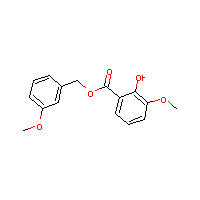

In [163]:
draw_mol_by_smiles('COc1cccc(COC(=O)c2cccc(OC)c2O)c1')

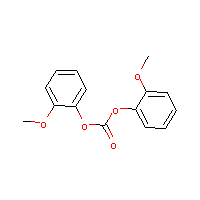

In [164]:
draw_mol_by_smiles('COc1ccccc1OC(=O)Oc1ccccc1OC')

In [144]:
x_embedding2.loc['COc1ccccc1OC(=O)Oc1ccccc1OC'].values.reshape(1,-1)

array([[-1.7400475 ,  8.122423  , -1.7562625 ,  1.207755  ,  0.97133076,
        -1.7281684 ,  4.42106   , -1.7268825 , -1.1159489 , -1.7408365 ,
         0.24293756,  1.847097  ,  1.6051044 ,  1.2472619 , -0.8518298 ,
         1.2280526 , -0.68945897,  1.0293088 , -1.507268  ,  1.4460465 ,
        -1.3534151 , -1.0852808 ,  3.8655915 , -1.2245071 , -1.7580503 ,
        -1.690312  , -0.8450131 , -1.3267522 , 11.165923  , -1.7211838 ]],
      dtype=float32)

In [145]:
print_closest_words(x_embedding=x_embedding2, x_query='COc1ccccc1OC(=O)Oc1ccccc1OC')

COc1ccc(OCC(=O)Oc2ccc(OC)cc2)cc1 [0.2476424]
COc1ccc(OC(=O)COc2ccccc2OC)cc1 [0.2476424]
COc1ccccc1OCC(=O)Oc1ccccc1OC [0.2476424]
COc1ccc(OC(=O)COc2cccc(OC)c2)cc1 [0.2476424]
COc1cc(OC)c(C(=O)OCc2ccccc2)cc1OC [0.4751656]


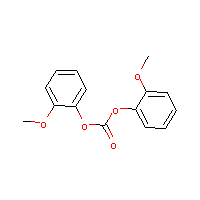

In [146]:
draw_mol_by_smiles('COc1ccccc1OC(=O)Oc1ccccc1OC')

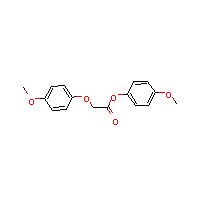

In [147]:
draw_mol_by_smiles('COc1ccc(OCC(=O)Oc2ccc(OC)cc2)cc1')

In [148]:
print_closest_words(x_embedding=x_embedding2, x_query='COC(=O)c1cc(Br)cc(Br)c1O')

COC(=O)c1cc(Br)c(O)c(Br)c1 [0.]
COC(=O)Cc1cc(Br)c(O)c(Br)c1 [0.3314439]
COC(=O)CCc1cc(Br)c(O)c(Br)c1 [0.64642835]
CCOC(=O)c1c(O)cc(Br)cc1F [0.8864195]
CC(=O)c1cc(Br)c(F)cc1OCCCO [0.9609371]


In [149]:
print_closest_words(x_embedding=x_embedding2, x_query='COC(=O)c1cc(Br)cc(Br)c1O', add_vec=ch2)

COc1c(Br)cc(C(C)=O)cc1Br [0.8278422]
CC(=O)Oc1cc(Br)c(C)cc1Br [0.8278422]
CC(=O)c1cc(Br)c(O)c(Br)c1O [0.8278422]
CC(=O)Oc1c(Br)cc(C)cc1Br [0.8278422]
COCC(=O)c1cc(Br)ccc1Br [0.8278422]


In [150]:
print_closest_words(x_embedding=x_embedding2, x_query='CCOC(=O)COc1ccc(Br)cc1', add_vec=ch2)

CCC(=O)c1cc(Br)c(OC)cc1O [0.59857804]
COc1ccc(C(=O)CCO)cc1Br [0.59857804]
O=C(CO)CCOc1ccccc1Br [0.59857804]
O=C(CO)CCOc1cccc(Br)c1 [0.59857804]
O=C(CO)CCOc1ccc(Br)cc1 [0.59857804]


In [151]:
print_closest_words(x_embedding=x_embedding2, x_query='O=C(OCC1CCCO1)c1cccc(Br)c1')

O=C(OCC1CCCO1)c1ccccc1Br [1.1920929e-07]
CCOC(=O)C1COc2ccc(Br)cc21 [1.1920929e-07]
O=C(Cc1cccc(Br)c1)OC1CCOC1 [1.1920929e-07]
CCOC(=O)C1Cc2cccc(Br)c2O1 [1.1920929e-07]
O=C(COCC1CCOC1)c1ccc(Br)cc1 [0.30967838]


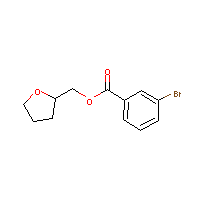

In [152]:
draw_mol_by_smiles('O=C(OCC1CCCO1)c1cccc(Br)c1')

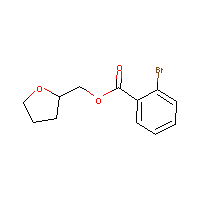

In [153]:
draw_mol_by_smiles('O=C(OCC1CCCO1)c1ccccc1Br')

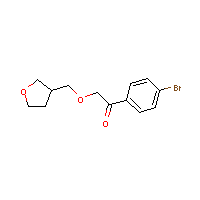

In [154]:
draw_mol_by_smiles('O=C(COCC1CCOC1)c1ccc(Br)cc1')

In [155]:
o = get_minus_result(x_embedding=x_embedding2, x='O=c1c(O)c(-c2ccc(O)cc2)oc2ccccc12', y='O=c1c(O)c(-c2ccc(O)cc2)oc2cccc(O)c12')
o

array([[ 2.3546076e-01, -9.2429113e-01, -9.6678734e-05, -2.8019696e-01,
         5.7322025e-02,  2.7282667e-01, -7.8666323e-01, -3.7044525e-02,
        -6.0613990e-02, -1.6450882e-05,  2.2675842e-01, -3.8749033e-01,
        -5.4004669e-02,  8.5949898e-03, -9.5927715e-04, -7.1066380e-02,
        -7.4346304e-02,  1.1248946e-02,  1.1036050e-01, -4.0107518e-01,
         1.4762437e-01,  4.8563933e-01, -3.2737255e-01,  2.7357996e-01,
         5.4061413e-04,  2.0986903e-01,  1.0140395e-01,  1.2186682e-01,
        -9.5445585e-01,  8.4623575e-02]], dtype=float32)

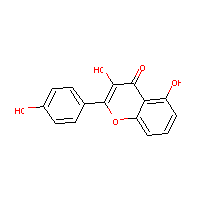

In [156]:
draw_mol_by_smiles('O=c1c(O)c(-c2ccc(O)cc2)oc2cccc(O)c12')

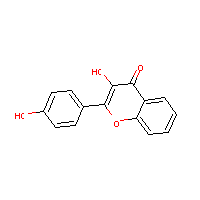

In [157]:
draw_mol_by_smiles('O=c1c(O)c(-c2ccc(O)cc2)oc2ccccc12')

In [158]:
print_closest_words(x_embedding=x_embedding2, x_query='Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1', add_vec=o)

Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1 [1.8722073]
N#Cc1nc(Cc2ccccc2)oc1N1CCCC1 [1.8722073]
Cc1ccccc1-c1nc(C#N)c(N2CCCC2)o1 [1.8722073]
Cc1cccc(-c2nc(C#N)c(N3CCCC3)o2)c1 [1.8722073]
N#Cc1nc(-c2ccccc2)oc1N1CCCCC1 [2.6837091]


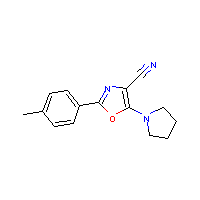

In [237]:
draw_mol_by_smiles('Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1')

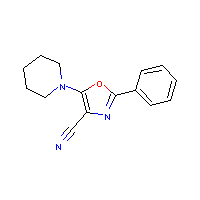

In [160]:
draw_mol_by_smiles('N#Cc1nc(-c2ccccc2)oc1N1CCCCC1')

In [161]:
print_closest_words(x_embedding=x_embedding2, x_query='Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1', add_vec=ch2)

Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1 [1.8267605]
N#Cc1nc(Cc2ccccc2)oc1N1CCCC1 [1.8267605]
Cc1ccccc1-c1nc(C#N)c(N2CCCC2)o1 [1.8267605]
Cc1cccc(-c2nc(C#N)c(N3CCCC3)o2)c1 [1.8267605]
N#Cc1nc(-c2ccccc2)oc1N1CCCCC1 [2.5910547]


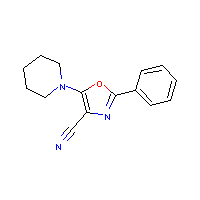

In [162]:
draw_mol_by_smiles('N#Cc1nc(-c2ccccc2)oc1N1CCCCC1')  # good example

##### similarity in fragment embedding

In [165]:
print_closest_words(x_embedding=frag2vec, x_query='CC')

CN [2.07466464]
C1=CCCC=CC1 [2.14207096]
C1=CCCCC=C1 [2.16296164]
C1CCCC1 [2.31532599]
C1=CCC=NC=C1 [2.32695495]


In [166]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CC')

C [1.3998404]
CN [2.8189292]
CBr [3.2146254]
CF [3.3278666]
CCl [3.368542]


In [167]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CO')

C [3.2235312]
CC [3.5713756]
CN [4.3684893]
CS [4.620403]
CBr [4.8345466]


In [169]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C=C')

C=O [6.4880624]
CC [6.9603767]
CN [7.2390494]
C [7.3631477]
CF [7.3641043]


In [170]:
double_bond = get_minus_result(x_embedding=frag_embedding_df, x='C=C', y='CC')
double_bond

array([[-0.9069163 ,  0.16055357, -1.4519948 ,  0.04600358,  2.1111865 ,
         0.94069785, -0.33108783,  0.00733316,  0.02371764, -0.3574866 ,
         2.11189   ,  1.2330089 ,  1.6423912 ,  1.6493165 ,  0.5750477 ,
        -0.00603211,  1.0300648 ,  3.5397837 ,  1.1197469 , -0.08535624,
         0.27110136,  0.1865567 , -0.07768476,  1.6632302 ,  1.0584667 ,
        -1.3718281 ,  0.21978402, -2.4010406 ,  0.13508382,  1.2698841 ]],
      dtype=float32)

In [171]:
double_bond2 = get_minus_result(x_embedding=frag_embedding_df, x='C=O', y='CO')
double_bond2

array([[-1.0754894 , -0.05029994, -0.9682723 ,  0.01637173,  3.1190686 ,
         0.2904792 , -1.7564679 , -0.03005278, -0.39539814, -1.7665595 ,
         0.6097307 , -1.3078978 ,  2.4683962 ,  0.09237754, -0.7451295 ,
         0.1150409 ,  0.30381685,  2.800765  ,  0.45277417,  0.6171602 ,
         0.23249733,  0.35240924,  0.04863632, -0.2631368 , -0.09964848,
         0.67061937,  1.0381212 , -0.4477899 ,  1.2853549 , -0.17619288]],
      dtype=float32)

In [172]:
double_bond3 = get_minus_result(x_embedding=frag_embedding_df, x='C=S', y='CS')
double_bond3

array([[-1.3957481 , -0.08041072, -1.3055601 , -0.00601339,  1.2437274 ,
        -1.1243701 , -2.16369   ,  0.43716812, -1.4693278 ,  0.51733625,
        -1.0354639 , -1.0465071 ,  1.3476306 ,  0.04740214,  1.6594639 ,
         0.3608284 ,  0.13601375,  1.9363195 , -0.7505995 , -0.16096044,
        -0.02901536,  1.1739947 , -0.31962013, -0.18861854, -0.6297839 ,
        -0.17125994,  0.12829292,  1.6007774 ,  1.075871  ,  0.00354147]],
      dtype=float32)

In [173]:
double_bond4 = get_minus_result(x_embedding=frag_embedding_df, x='C=N', y='CN')
double_bond4

array([[-0.8261296 ,  0.41114938, -1.6881613 ,  0.32293153,  3.2755349 ,
         0.18846641, -2.459127  ,  5.5993958 , -0.1279794 , -0.3589108 ,
        -3.6940436 , -2.097483  ,  2.7329798 ,  0.21572757,  2.1169827 ,
         2.0556507 , -0.6032865 ,  4.818708  , -1.7358465 ,  0.1737749 ,
        -1.02369   ,  2.7960978 , -1.5079298 ,  1.5021176 , -1.8424561 ,
        -0.30885392,  0.1059857 ,  3.3131592 , -0.19692159,  3.029746  ]],
      dtype=float32)

In [174]:
double_bond_mean = np.concatenate((double_bond, double_bond2, double_bond3, double_bond4)).mean(axis=0)
double_bond_mean

array([-1.0510708 ,  0.11024807, -1.3534971 ,  0.09482336,  2.4373794 ,
        0.07381836, -1.6775932 ,  1.5034611 , -0.49224693, -0.49140516,
       -0.5019717 , -0.80471975,  2.0478494 ,  0.5012059 ,  0.9015912 ,
        0.631372  ,  0.21665221,  3.2738938 , -0.22848123,  0.1361546 ,
       -0.13727666,  1.1272646 , -0.4641496 ,  0.67839813, -0.37835544,
       -0.29533064,  0.37304598,  0.51627654,  0.57484704,  1.0317447 ],
      dtype=float32)

In [177]:
cal_distance(double_bond, double_bond3)

array([[8.072913]], dtype=float32)

In [182]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CC', add_vec=double_bond2)

C=O [3.5713756]
C=C [6.220685]
CC [6.2624974]
CF [6.711393]
C1=CC=CCC=C1 [6.847985]


In [184]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CO', add_vec=double_bond2)

C=O [2.0647654e-07]
CC [6.119925]
CO [6.2624974]
C=C [6.4880624]
C [6.5317984]


In [185]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CS', add_vec=double_bond2)

C=O [4.620403]
C=S [5.671829]
CC [5.991187]
CS [6.2624974]
C [6.283827]


In [194]:
print_closest_words(x_embedding=frag_embedding_df, x_query='OS', add_vec=double_bond_mean)

OS [5.98756]
C1=CSCO1 [8.344847]
C1=CSCCC1 [8.429715]
C1=CSCCCC1 [8.565202]
C1=CNSCC1 [8.6135645]


In [199]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C1CC1', add_vec=double_bond)

C=C [6.690533]
C1CC1 [6.9603767]
C1=CC2C=CC(C1)CNC2 [7.3189626]
C1=CCC2CC(C=CN2)C1 [7.326511]
C1=CC2CCCCC(CC1)C2 [7.4690814]


##### triple bond

In [196]:
tri_bond = get_minus_result(x_embedding=frag_embedding_df, x='C#C', y='CC')

In [203]:
# print_closest_words(x_embedding=frag_embedding_df, x_query=tri_bond)

In [197]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CN', add_vec=tri_bond)

C#C [2.8189292]
C#N [4.3066435]
C [6.3235435]
CC [6.3629184]
CCl [6.668081]


In [198]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CN')

CC [2.8189292]
C [3.1315868]
CO [4.3684893]
C1=CC=CNC=C1 [4.480303]
CBr [4.4869633]


##### aromaticity, 芳香性

In [200]:
arom = get_minus_result(x_embedding=frag_embedding_df, x='C1=CC=CC=C1', y='C1CCCCC1')

In [201]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C1CCOCC1', add_vec=arom)

C1=CC=COC=C1 [3.5612214]
C1=COCC1 [3.8171299]
C1=COC=C1 [3.8982756]
C1=CCCOC=C1 [4.8638096]
C1=CCOC=CC1 [4.893565]


In [1]:
def draw_multiple_mol(smiles_list, mols_per_row=4, file_path=None, legend=None):
    mols = []
    for i in smiles_list:
        mols.append(Chem.MolFromSmiles(i))
    mols_per_row = min(len(smiles_list), mols_per_row)
    if legend is None:
        img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(300, 160), useSVG=True)
    else:
        img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(300, 160), useSVG=True, legend=legend)
    if file_path:
        with open(file_path, 'w') as f_handle:
            f_handle.write(img.data)
    return img

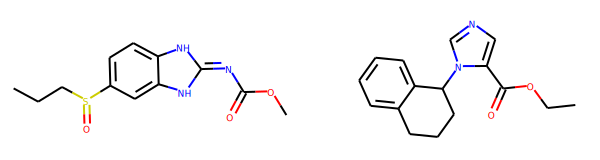

In [46]:
smiles = ['CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1', 'CCOC(=O)c1cncn1C1CCCc2ccccc21']
draw_multiple_mol(smiles, file_path='./figures/two_mols2.svg')

In [35]:
with open('./figures/two_mol.svg', 'w') as f_handle:
    f_handle.write(img.data)

In [22]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

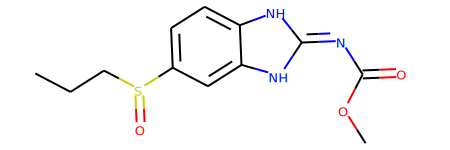

In [23]:
svg = moltosvg(mol=mols[0])
SVG(svg)

In [25]:
type(svg)

str